<a href="https://colab.research.google.com/github/shreyanshchordia/pos-tagging-using-recurrent-neural-network/blob/master/POS_Tagging_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Downloading required libraries**

In [0]:
# !pip install nltk
# !pip install numpy
# !pip install tensorflow
# !pip install keras
# !pip install sklearn
# !pip install matplotlib
# !pip install regex
# !pip install mxnet
# !pip install gluonnlp
# !pip install random
# !pip install h5py

# **Downloading the dataset with pre tokenized sentences**

In [0]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# **Importing libraries and modules**

In [0]:
import random
import numpy as np
from nltk.corpus import brown
from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp_
import re
nlp_.utils.check_version('0.7.0')
from nltk.tokenize import RegexpTokenizer

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed,Embedding, Activation,Flatten,Bidirectional,Input,concatenate
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# **Loading and examining the dataset**

In [0]:
dataset = brown.tagged_sents(tagset='universal')
print("Number of sentences in dataset-",len(dataset))

Number of sentences in dataset- 57340


In [0]:
print(random.choice(dataset))

[('At', 'ADP'), ('last', 'ADJ'), (',', '.'), ('when', 'ADV'), ('I', 'PRON'), ('put', 'VERB'), ('it', 'PRON'), ('to', 'ADP'), ('him', 'PRON'), ('directly', 'ADV'), (',', '.'), ('the', 'DET'), ('clerk', 'NOUN'), ('was', 'VERB'), ('forced', 'VERB'), ('to', 'PRT'), ('admit', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('delay', 'NOUN'), ('in', 'ADP'), ('my', 'DET'), ('case', 'NOUN'), ('was', 'VERB'), ('unusual', 'ADJ'), ('.', '.')]


In [0]:
sentence_dataset = []
tag_dataset = []
for sentence in dataset:
    sent_list = []
    tag_list = []
    for tagged_word in sentence:
        sent_list.append(tagged_word[0])
        tag_list.append(tagged_word[1])
    sentence_dataset.append(sent_list)
    tag_dataset.append(tag_list)

**Note** - The next cell removes sentences having the tag 'X'.

In case you do not want to train your model on unknown tag 'X'.

I prefered to keep my model robust so that it can deal with gibberish sentences in a better way.

In [0]:
# to_be_removed_indexes = []
# for i,tag_list in enumerate(tag_dataset):
#     for tag in tag_list:
#         if tag=='X':
#             to_be_removed_indexes.append(i)
#             break

# sentence_dataset = [sent for i,sent in enumerate(sentence_dataset) if i not in to_be_removed_indexes]
# tag_dataset = [sent for i,sent in enumerate(tag_dataset) if i not in to_be_removed_indexes]

In [0]:
rand = random.randint(0,len(sentence_dataset))
print("Random tokenized sentence from the dataset-",sentence_dataset[rand])
print("\nTags for the same random tokenized sentence from the dataset-",tag_dataset[rand])
print("\nLength of our dataset-",len(sentence_dataset))

Random tokenized sentence from the dataset- ['By', 'all', 'means', 'the', 'most', 'important', 'distinction', 'is', 'that', 'between', 'those', 'total-cost', 'apportionments', 'which', 'superimpose', 'a', 'distribution', 'of', 'admittedly', 'unallocable', 'cost', 'residues', 'on', 'estimates', 'of', 'incremental', 'or', 'marginal', 'costs', ',', 'and', 'those', 'other', 'apportionments', 'which', 'recognize', 'no', 'difference', 'between', 'true', 'cost', 'allocation', 'and', 'mere', 'total-cost', 'distribution', '.']

Tags for the same random tokenized sentence from the dataset- ['ADP', 'PRT', 'NOUN', 'DET', 'ADV', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'DET', 'NOUN', 'NOUN', 'DET', 'VERB', 'DET', 'NOUN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADJ', 'CONJ', 'ADJ', 'NOUN', '.', 'CONJ', 'DET', 'ADJ', 'NOUN', 'DET', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'CONJ', 'ADJ', 'NOUN', 'NOUN', '.']

Length of our dataset- 57340


# **Loading the pre trained embeddings of words**

In [0]:
nlp_.embedding.list_sources('glove')

['glove.42B.300d',
 'glove.6B.100d',
 'glove.6B.200d',
 'glove.6B.300d',
 'glove.6B.50d',
 'glove.840B.300d',
 'glove.twitter.27B.100d',
 'glove.twitter.27B.200d',
 'glove.twitter.27B.25d',
 'glove.twitter.27B.50d']

In [0]:
glove_6b50d = nlp_.embedding.create('glove', source='glove.6B.50d')

In [0]:
emb = nlp_.Vocab(nlp_.data.Counter(glove_6b50d.idx_to_token))
emb.set_embedding(glove_6b50d)

In [0]:
len(emb.idx_to_token)

400004

In [0]:
print(emb['man'])
print(emb.idx_to_token[232539])
print(emb.embedding['dhfbhnv']) # handles unkown words as well
print(emb.embedding['man'])

232539
man

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
<NDArray 50 @cpu(0)>

[-0.094386  0.43007  -0.17224  -0.45529   1.6447    0.40335  -0.37263
  0.25071  -0.10588   0.10778  -0.10848   0.15181  -0.65396   0.55054
  0.59591  -0.46278   0.11847   0.64448  -0.70948   0.23947  -0.82905
  1.272     0.033021  0.2935    0.3911   -2.8094   -0.70745   0.4106
  0.3894   -0.2913    2.6124   -0.34576  -0.16832   0.25154   0.31216
  0.31639   0.12539  -0.012646  0.22297  -0.56585  -0.086264  0.62549
 -0.0576    0.29375   0.66005  -0.53115  -0.48233  -0.97925   0.53135
 -0.11725 ]
<NDArray 50 @cpu(0)>


# **Making embedding matrix over the entire vocabulary of 4,00,004 words**

This matrix matches indexes of the words to their embeddings

For example:

    embedding_matrix[0] = embeddings of the word '<unk>'
    embedding_matrix[232539] = embeddings of the word 'man'


In [0]:
embedding_matrix = []
for i,word in enumerate(emb.idx_to_token):
    embedding_matrix.append(emb.embedding[word].asnumpy())

In [0]:
embedding_matrix = np.asarray(embedding_matrix)
print(embedding_matrix.shape)

(400004, 50)


# **Removing 'long' sentences from the dataset and keeping the maximum length == 50**

In [0]:
to_be_removed_indexes = []
for i,sentence in enumerate(sentence_dataset):
    if(len(sentence)>50): to_be_removed_indexes.append(i)

sentence_dataset = [sent for i,sent in enumerate(sentence_dataset) if i not in to_be_removed_indexes]
tag_dataset = [sent for i,sent in enumerate(tag_dataset) if i not in to_be_removed_indexes]

# **Adding <eos<x>> at the ends of all sentences and hence the new tag 'EOS'**

In [0]:
for sentence in  sentence_dataset:
    sentence.append('<eos>')
for tag_list in tag_dataset:
    tag_list.append('EOS')

**Note** - Due to addition of `<eos>` in all sentences the maximum length becomes 51

## **Padding all the sentences to `MAX_LENGTH` with <pad<x>> and hence the new tag 'PAD'**

`MAX_LENGTH` : Maximum number of time steps

In [0]:
MAX_LENGTH = np.max(np.asarray([len(s) for s in sentence_dataset]))
print(MAX_LENGTH)

51


In [0]:
padded_sent_dataset = pad_sequences(sequences=sentence_dataset,dtype=object,maxlen=MAX_LENGTH,padding='post',value='<pad>')
padded_tag_dataset = pad_sequences(sequences=tag_dataset,dtype=object,maxlen=MAX_LENGTH,padding='post',value='PAD')

In [0]:
print(random.choice(padded_sent_dataset))
print("\n",random.choice(padded_tag_dataset))

['He' 'is' 'appreciative' 'of' 'the' 'expert' 'help' 'available' 'to'
 'him' 'and' 'draws' 'these' 'resources' 'into' 'play' ',' 'taking' 'care'
 'to' 'examine' 'at' 'least' 'some' 'of' 'the' 'raw' 'material' 'which'
 'underlies' 'their' 'frequently' 'policy-oriented' 'conclusions' '.'
 '<eos>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>']

 ['NOUN' 'ADP' 'NOUN' 'CONJ' 'NOUN' 'VERB' 'DET' 'NOUN' 'ADP' 'DET' 'VERB'
 'CONJ' 'DET' 'NOUN' '.' 'EOS' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD' 'PAD'
 'PAD' 'PAD' 'PAD' 'PAD']


# **Turning the sentences and tags to Model accepting values**

In [0]:
dataset = padded_sent_dataset.copy()
for sentence in dataset:
    for i in range(MAX_LENGTH):
        sentence[i] = emb[sentence[i].lower()]

In [0]:
print(random.choice(padded_sent_dataset))
print("\n",random.choice(dataset))

['Along' 'the' '127-mile' 'route' 'through' 'Great' 'Smoky' 'Mountains'
 'National' 'Park' 'you' 'can' 'photograph' 'the' 'breath-taking' 'peaks'
 ',' 'gorges' 'and' 'valleys' 'which' 'come' 'into' 'view' 'at' 'every'
 'turn' '.' '<eos>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>']

 [2482 455 357269 61774 268049 357269 247381 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [0]:
set_of_tags = set()
for tag_list in padded_tag_dataset:
    for tag in tag_list:
        set_of_tags.add(tag)
print("Tags :", set_of_tags,"\n\nLength of the set :",len(set_of_tags))

Tags : {'DET', 'NOUN', 'ADJ', 'ADV', 'ADP', 'VERB', 'PRON', 'CONJ', 'EOS', 'PAD', 'PRT', '.', 'NUM', 'X'} 

Length of the set : 14


In [0]:
dict_of_tags = {tag: i for i,tag in enumerate(sorted(set_of_tags))}
id2tag = {i: tag for i,tag in enumerate(sorted(set_of_tags))}

In [0]:
output_dataset = [] 
for tag_list in padded_tag_dataset:
    temp = []
    for tag in tag_list:
        temp.append(dict_of_tags[tag])
    output_dataset.append(np.asarray(temp))
output_dataset = np.asarray(output_dataset)
print(output_dataset.shape)

(55708, 51)


In [0]:
output_dataset = to_categorical(output_dataset, num_classes=len(dict_of_tags))
print(output_dataset.shape)

(55708, 51, 14)


# **Seperating the dataset into Training and Testing set**

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset,output_dataset,test_size=0.3,shuffle=True)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(38995, 51) (16713, 51) (38995, 51, 14) (16713, 51, 14)


# **Initializing helping functions**

In [0]:
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)

        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy

    return ignore_accuracy

################################################################################

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def preprocessing(sentence,MAX_LEN):
    if(type(sentence)=='str'):
        sentence = tokenizer.tokenize(sentence)
    sentence.append('<eos>')
    sequence = [sentence]
    sequence = pad_sequences(sequences=sequence,dtype=object,maxlen=MAX_LENGTH,padding='post',value='<pad>')
    for sentence in sequence:
        for i in range(MAX_LEN):
            sentence[i] = emb[sentence[i].lower()]

    return sequence
        
################################################################################

def predict(model,sentence):
    sentence = preprocessing(sentence,MAX_LENGTH)
    pred = model.predict(sentence)
    pred = pred[0]

    output = []
    for i,tag in enumerate(pred):
        id = np.argmax(tag)
        if(id==9): break
        output.append(id2tag[id])

    return output 

################################################################################

def plot_model_history(model,history):
    # summarize history for accuracy
    plt.figure(figsize=(10,8))
    plt.plot(history.history['ignore_accuracy'])
    plt.plot(history.history['val_ignore_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
################################################################################

# ~~~~~~~~~~~~~~~~~~ Following functions are for model3 ~~~~~~~~~~~~~~~~~~~~~~ #

def predict_v2(model,sentence,index):
    f_input = feature_map[index]
    f_input = f_input.reshape(-1,f_input.shape[0],f_input.shape[1])
    sentence = preprocessing(sentence,MAX_LENGTH)
    pred = model.predict([sentence,f_input])
    pred = pred[0]

    output = []
    for i,tag in enumerate(pred):
        id = np.argmax(tag)
        if(id==9): break
        output.append(id2tag[id])

    return output

################################################################################

def get_features(sentence):
    '''
    In features we will have:
    1) Boolean value for: Is token the first index?
    2) Boolean value for: Is token the last index?
    3) Boolean value for: Is token in CAPS?
    4) Boolean value for: Is first character in CAPS?
    5) Boolean value for: Is first character a number?
    6) Boolean value for: Is token a symbol?
    '''
    sentence_features = []
    for index,word in enumerate(sentence):
        feature_list = []
        # converting the MXnet array to numpy and then appending it to the feature list
        if(word=='<pad>' or word=='<eos>'): feature_list += [0,0,0,0,0,0]
        else:
            feature_list.append(int(index==0))
            feature_list.append(int(index==len(sentence)-1))
            feature_list.append(int(word.isalpha() and word.upper()==word))
            feature_list.append(int(word.isalpha() and word[0].upper()==word[0]))
            feature_list.append(int(word[0].isnumeric()))
            feature_list.append(int(word[0] in ['!','@','#','$','%','^','&','*','(',')',';',
                                                '"',"'",':','{','}','[',']','-','_','+','=',
                                                '~','``','`','.',',','/','?','<','>','|']))
        sentence_features.append(feature_list)
    
    return (np.asarray(sentence_features)).reshape(-1,6)

################################################################################


# **Different models, their training and evaluation**

## **Uni-directional single layer LSTM model**

In [0]:
model1 = Sequential(name="Uni directional single layer LSTM")
#model1.add(InputLayer(input_shape=(MAX_LENGTH,)))
model1.add(Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False,input_length=MAX_LENGTH,name='embedding_1'))
model1.add(LSTM(64, return_sequences=True,name='lstm_1'))
model1.add(TimeDistributed(Dense(len(dict_of_tags),activation='softmax',name='dense_1'),name='timedist_1'))
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',ignore_class_accuracy(9)])

model1.summary()

Model: "Uni directional single layer LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 50)            20000200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 64)            29440     
_________________________________________________________________
timedist_1 (TimeDistributed) (None, 51, 14)            910       
Total params: 20,030,550
Trainable params: 30,350
Non-trainable params: 20,000,200
_________________________________________________________________


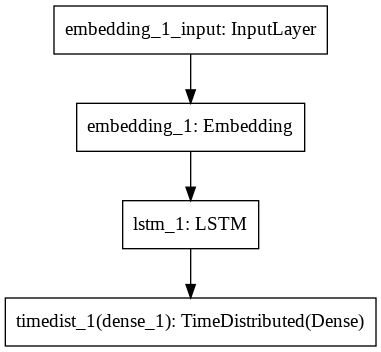

In [0]:
plot_model(model1)

### Training

In [0]:
history1 = model1.fit(X_train,Y_train,epochs=20,batch_size=128,validation_split=0.2,verbose=1)

Train on 31196 samples, validate on 7799 samples
Epoch 1/20
31196/31196 [==============================] - 18s 565us/step - loss: 0.8071 - accuracy: 0.7846 - ignore_accuracy: 0.4869 - val_loss: 0.4308 - val_accuracy: 0.8709 - val_ignore_accuracy: 0.6769
Epoch 2/20
31196/31196 [==============================] - 17s 550us/step - loss: 0.3361 - accuracy: 0.8980 - ignore_accuracy: 0.7424 - val_loss: 0.2816 - val_accuracy: 0.9138 - val_ignore_accuracy: 0.7829
Epoch 3/20
31196/31196 [==============================] - 17s 553us/step - loss: 0.2462 - accuracy: 0.9254 - ignore_accuracy: 0.8111 - val_loss: 0.2226 - val_accuracy: 0.9324 - val_ignore_accuracy: 0.8293
Epoch 4/20
31196/31196 [==============================] - 17s 545us/step - loss: 0.2010 - accuracy: 0.9385 - ignore_accuracy: 0.8440 - val_loss: 0.1874 - val_accuracy: 0.9420 - val_ignore_accuracy: 0.8536
Epoch 5/20
31196/31196 [==============================] - 17s 542us/step - loss: 0.1723 - accuracy: 0.9463 - ignore_accuracy: 0.863

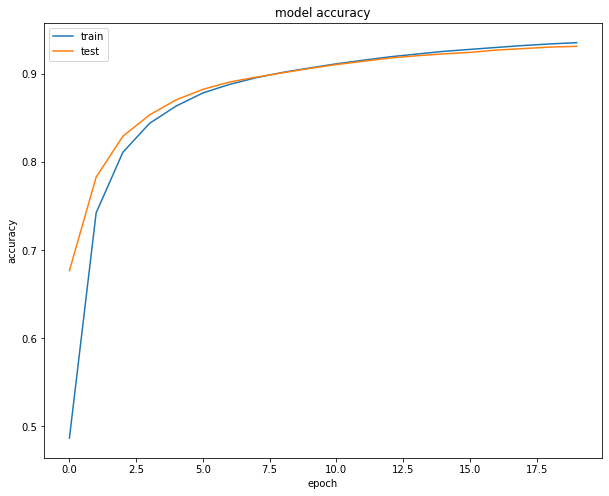

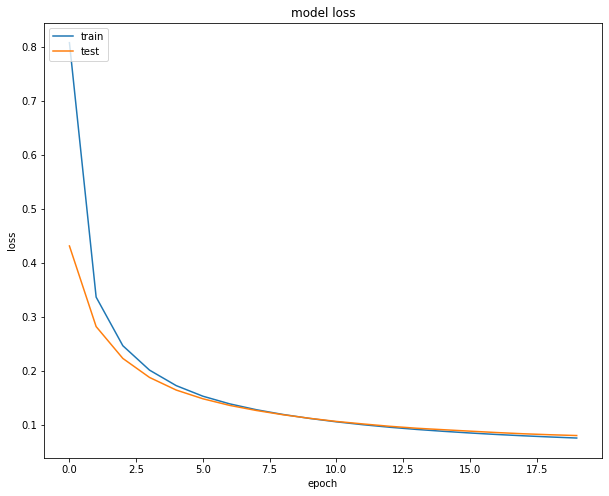

In [0]:
plot_model_history(model1,history1)

### Evaluation

In [0]:
model1.evaluate(X_test,Y_test)

16713/16713 [==============================] - 5s 277us/step


[0.07795659738387124, 0.9733669757843018, 0.9320371747016907]

Loss of 0.08

And accuracy is 93.2% which can surely be increased with larger number of epochs since there are no signs of any kind of variance

In [0]:
tester = random.randint(0,len(sentence_dataset))
print(sentence_dataset[tester])
print(tag_dataset[tester])
print(predict(model1,sentence_dataset[tester]))

['The', 'moment', 'simultaneously', 'revealed', 'that', 'in', 'the', 'crisis', 'our', 'policy', 'ran', 'counter', 'to', 'that', 'of', 'all', 'our', 'NATO', 'allies', ',', 'to', 'the', 'entire', 'Western', 'community', '.', '<eos>']
['DET', 'NOUN', 'ADV', 'VERB', 'ADP', 'ADP', 'DET', 'NOUN', 'DET', 'NOUN', 'VERB', 'ADV', 'ADP', 'DET', 'ADP', 'PRT', 'DET', 'NOUN', 'NOUN', '.', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', '.', 'EOS']
['DET', 'NOUN', 'ADV', 'VERB', 'ADP', 'ADP', 'DET', 'NOUN', 'DET', 'NOUN', 'VERB', 'NOUN', 'ADP', 'DET', 'ADP', 'PRT', 'DET', 'NOUN', 'NOUN', '.', 'PRT', 'DET', 'ADJ', 'ADJ', 'NOUN', '.', 'EOS']


In [0]:
model1.save('model1.h5')

In [0]:
from keras.models import load_model
model = load_model('model1.h5',custom_objects={'ignore_accuracy':ignore_class_accuracy(9)})
model.evaluate(X_test,Y_test)

16713/16713 [==============================] - 5s 297us/step


[0.07795659738387124, 0.9733669757843018, 0.9320371747016907]

## **Bi-directional LSTM layer Model**

In [0]:
model2 = Sequential(name="Bi directional single layer LSTM")
model2.add(Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False,input_length=MAX_LENGTH,name='embedding_1'))
model2.add(Bidirectional(LSTM(64, return_sequences=True),name='bi_lstm_1'))
model2.add(TimeDistributed(Dense(len(dict_of_tags),activation='softmax',name='dense_1'),name='timedist_1'))
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',ignore_class_accuracy(9)])
 
model2.summary()

Model: "Bi directional single layer LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 50)            20000200  
_________________________________________________________________
bi_lstm_1 (Bidirectional)    (None, 51, 128)           58880     
_________________________________________________________________
timedist_1 (TimeDistributed) (None, 51, 14)            1806      
Total params: 20,060,886
Trainable params: 60,686
Non-trainable params: 20,000,200
_________________________________________________________________


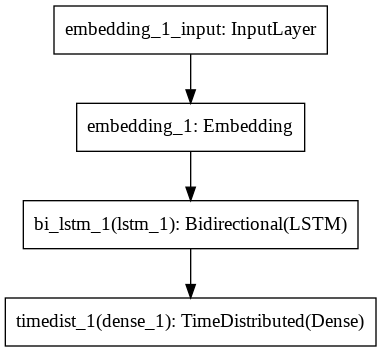

In [0]:
plot_model(model2)

### Training

In [0]:
history2 = model2.fit(X_train,Y_train,epochs=20,batch_size=128,validation_split=0.2,verbose=1)

Train on 31196 samples, validate on 7799 samples
Epoch 1/20
31196/31196 [==============================] - 23s 722us/step - loss: 0.6582 - accuracy: 0.8287 - ignore_accuracy: 0.5891 - val_loss: 0.2983 - val_accuracy: 0.9134 - val_ignore_accuracy: 0.7821
Epoch 2/20
31196/31196 [==============================] - 22s 712us/step - loss: 0.2369 - accuracy: 0.9297 - ignore_accuracy: 0.8215 - val_loss: 0.1996 - val_accuracy: 0.9396 - val_ignore_accuracy: 0.8476
Epoch 3/20
31196/31196 [==============================] - 23s 730us/step - loss: 0.1721 - accuracy: 0.9469 - ignore_accuracy: 0.8653 - val_loss: 0.1549 - val_accuracy: 0.9517 - val_ignore_accuracy: 0.8781
Epoch 4/20
31196/31196 [==============================] - 22s 721us/step - loss: 0.1384 - accuracy: 0.9571 - ignore_accuracy: 0.8911 - val_loss: 0.1294 - val_accuracy: 0.9597 - val_ignore_accuracy: 0.8981
Epoch 5/20
31196/31196 [==============================] - 23s 725us/step - loss: 0.1175 - accuracy: 0.9635 - ignore_accuracy: 0.907

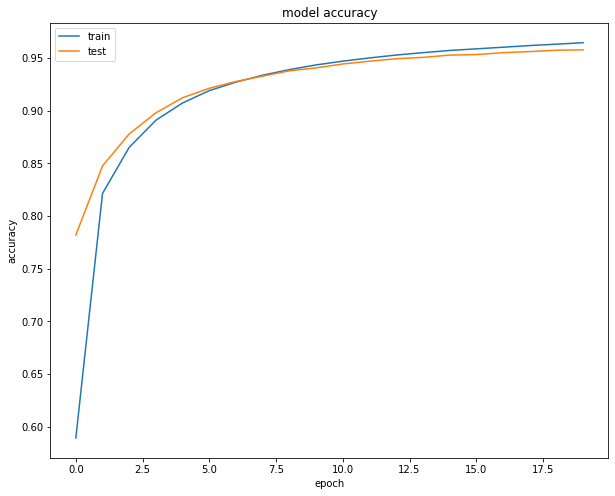

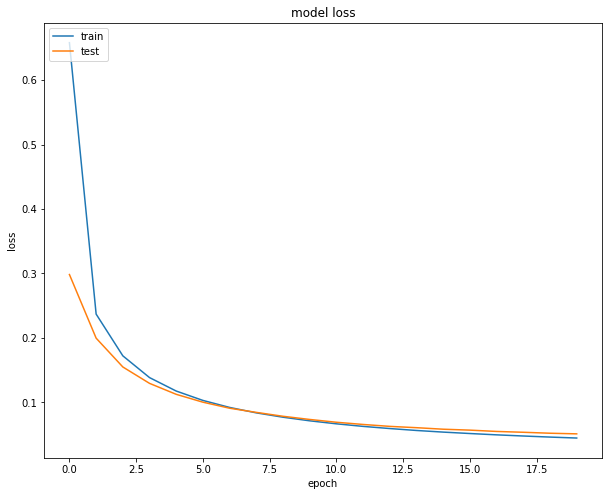

In [0]:
plot_model_history(model2,history2)

### Evaluation

In [0]:
model2.evaluate(X_test,Y_test)

16713/16713 [==============================] - 5s 325us/step


[0.04907932035209945, 0.9842895865440369, 0.9599391222000122]

Loss: 0.04


Accuracy: 96%

In [0]:
tester = random.randint(0,len(sentence_dataset))
print(sentence_dataset[tester])
print(tag_dataset[tester])
print(predict(model2,sentence_dataset[tester]))

['However', ',', 'despite', 'the', 'insight', 'of', 'many', 'of', 'his', 'observations', ',', 'his', 'own', 'conclusions', 'are', 'open', 'to', 'suspicion', 'because', 'of', 'his', 'failure', 'to', 'employ', 'at', 'all', 'times', 'the', 'correct', 'research', 'methods', '.', '<eos>']
['ADV', '.', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADP', 'DET', 'NOUN', '.', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'ADP', 'NOUN', 'ADV', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'ADP', 'PRT', 'NOUN', 'DET', 'ADJ', 'NOUN', 'NOUN', '.', 'EOS']
['ADV', '.', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADP', 'DET', 'NOUN', '.', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'ADP', 'VERB', 'ADV', 'ADP', 'DET', 'NOUN', 'PRT', 'VERB', 'ADP', 'PRT', 'NOUN', 'DET', 'ADJ', 'NOUN', 'NOUN', '.', 'EOS']


In [0]:
model2.save('model2.h5')

In [0]:
from keras.models import load_model
model = load_model('model2.h5',custom_objects={'ignore_accuracy':ignore_class_accuracy(9)})
model.evaluate(X_test,Y_test)

16713/16713 [==============================] - 5s 314us/step


[0.04907932035209945, 0.9842895865440369, 0.9599391222000122]

## **Embeddings + Features initiated Bidirectional LSTM model**

### Building the inputs for the model

In [0]:
sentence = ['Hi','I','am','12','year','old','?','HOW','CAN','12ou','DO','THIS','!?!']
print(get_features(sentence))

[[1 0 0 1 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 1 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 1]]


In [0]:
feature_map = []
for sentence in padded_sent_dataset:
    feature_map.append(get_features(sentence))

feature_map = np.asarray(feature_map)
print(feature_map.shape)

(55708, 51, 6)


In [0]:
# Model 3

# Unshuffled Split
X_train,X_test,Y_train,Y_test = train_test_split(dataset,output_dataset,test_size=0.3)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(38995, 51) (16713, 51) (38995, 51, 14) (16713, 51, 14)


In [0]:
(train_feature,test_feature) = feature_map[:X_train.shape[0]],feature_map[X_train.shape[0]:]
print(train_feature.shape,test_feature.shape)

(38995, 51, 6) (16713, 51, 6)


### Defining Model

In [0]:
# Model3 architecture

feature_input = Input(shape=(MAX_LENGTH,feature_map.shape[2]),name='features')
sequence_input = Input(shape=(MAX_LENGTH,),name='sequence')

A = Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False,input_length=MAX_LENGTH,name='embedding')(sequence_input)
A = Model(inputs=sequence_input, outputs=A)

M = concatenate([A.output,feature_input])
M = Bidirectional(LSTM(64, return_sequences=True),name='bi_lstm')(M)
M = TimeDistributed(Dense(len(dict_of_tags),activation='softmax',name='dense_1'),name='timedist')(M)
model3 = Model(inputs=[A.input, feature_input], outputs=M)

model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',ignore_class_accuracy(9)])

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 51)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 51, 50)       20000200    sequence[0][0]                   
__________________________________________________________________________________________________
features (InputLayer)           (None, 51, 6)        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 51, 56)       0           embedding[0][0]                  
                                                                 features[0][0]             

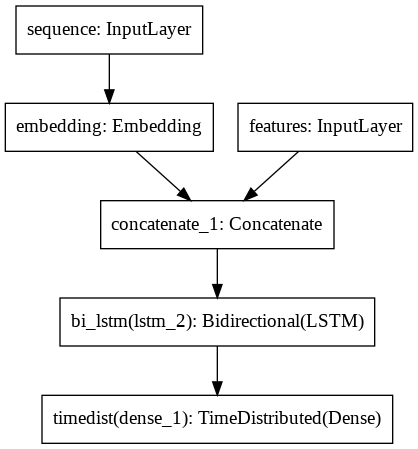

In [0]:
plot_model(model3)

### Training

In [0]:
history3 = model3.fit([X_train,train_feature],Y_train,epochs=20,batch_size=128,validation_split=0.2,verbose=1)

Train on 31196 samples, validate on 7799 samples
Epoch 1/20
31196/31196 [==============================] - 23s 742us/step - loss: 0.6435 - accuracy: 0.8279 - ignore_accuracy: 0.5873 - val_loss: 0.3062 - val_accuracy: 0.9115 - val_ignore_accuracy: 0.7792
Epoch 2/20
31196/31196 [==============================] - 23s 721us/step - loss: 0.2426 - accuracy: 0.9285 - ignore_accuracy: 0.8187 - val_loss: 0.2017 - val_accuracy: 0.9392 - val_ignore_accuracy: 0.8472
Epoch 3/20
31196/31196 [==============================] - 23s 730us/step - loss: 0.1724 - accuracy: 0.9476 - ignore_accuracy: 0.8669 - val_loss: 0.1532 - val_accuracy: 0.9529 - val_ignore_accuracy: 0.8818
Epoch 4/20
31196/31196 [==============================] - 23s 729us/step - loss: 0.1350 - accuracy: 0.9587 - ignore_accuracy: 0.8951 - val_loss: 0.1250 - val_accuracy: 0.9619 - val_ignore_accuracy: 0.9043
Epoch 5/20
31196/31196 [==============================] - 23s 734us/step - loss: 0.1131 - accuracy: 0.9653 - ignore_accuracy: 0.911

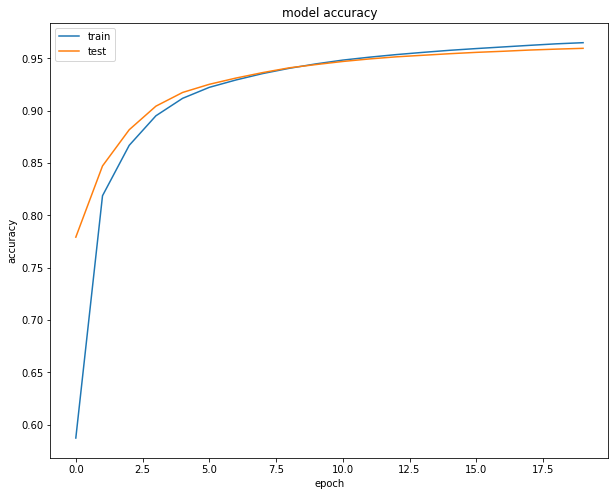

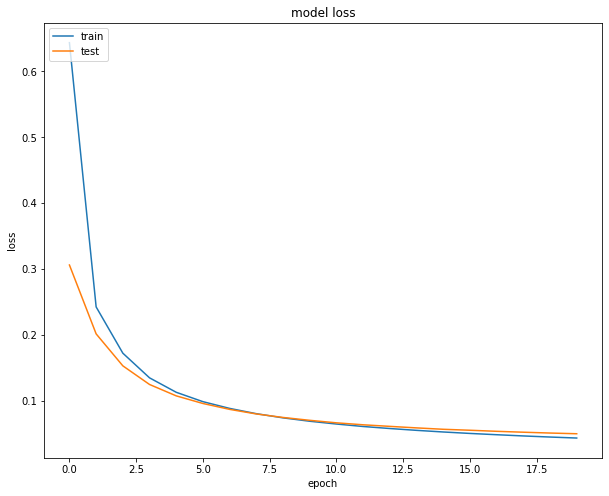

In [0]:
plot_model_history(model3,history3)

### Evaluation

In [0]:
model3.evaluate([X_test,test_feature],Y_test)

16713/16713 [==============================] - 5s 315us/step


[0.05046312431448478, 0.9838472604751587, 0.9587541222572327]

In [0]:
tester = random.randint(0,len(sentence_dataset))
print(sentence_dataset[tester])
print(tag_dataset[tester])
print(predict_v2(model3,sentence_dataset[tester],tester))

['The', 'Institute', 'also', 'planned', 'to', 'furnish', 'a', 'regular', 'series', 'of', 'articles', ',', 'beginning', 'in', 'the', 'fall', 'of', '1960', ',', 'on', 'its', 'more', 'significant', 'Scientific', 'Exhibits', '.', '<eos>']
['DET', 'NOUN', 'ADV', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', '.', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'NUM', '.', 'ADP', 'DET', 'ADV', 'ADJ', 'ADJ', 'NOUN', '.', 'EOS']
['DET', 'NOUN', 'ADV', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', '.', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'NUM', '.', 'ADP', 'DET', 'ADV', 'ADJ', 'ADJ', 'NOUN', '.', 'EOS']


In [0]:
model3.save('model3.h5')

In [0]:
from keras.models import load_model
model = load_model('model3.h5',custom_objects={'ignore_accuracy':ignore_class_accuracy(9)})
model.evaluate([X_test,test_feature],Y_test)

16713/16713 [==============================] - 5s 323us/step


[0.05046312431448478, 0.9838472604751587, 0.9587541222572327]